# Lone Wolf and Cub(s)

Submission for the TAMUDatathon 2020 "Stock Prediction" from Nam Tran (nam.nhat.tran@gmail.com). I'm participating in the context of a student, working on a master's degree in Statistics at Texas A&M. 

The name comes from the "Lone Wolf and Cub" manga. The "cub(s)" comes from me having three kids trying to bang on my keyboard. I was "Lone Wolf" since my wife works on the weekends, and I was working on this solo during their nap time and/or after I've put them down for the night.

The crux is that we have daily mystery stock data, a bunch of covariates, and we want to predict next day's return. The twist is that for a consequent buy/sell, we need to place a "fraction" for how much to stake our capital.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import seaborn as sns
import pickle

%matplotlib inline

seed = 42

## Look at the Data

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
dat = pd.read_csv("/Users/neuropunk/Documents/_source/_datawrangler/TAMUDatathon2020/stock_trader/mystery_stock_daily_train.csv")

In [4]:
dat.head()

,open_today,open_prev,high_prev,close_prev,low_prev,adj_close_prev,volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,...,LOGRET_1,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MAD_30,INC_1,INERTIA_20_14,KCL_20_2,KCB_20_2,KCU_20_2
0,0.001957,0.002339,0.002374,0.001953,0.001866,0.001952,7350820,0.002395,0.002702,0.002089,...,-0.176931,-0.000182,-0.000069,-0.000113,0.000326,0,37.019529,0.002018,0.002614,0.003210
1,0.001760,0.001957,0.002037,0.001780,0.001769,0.001779,9803180,0.002230,0.002534,0.001926,...,-0.092753,-0.000224,-0.000089,-0.000135,0.000333,0,35.504018,0.001944,0.002535,0.003125
2,0.001959,0.001760,0.001939,0.001939,0.001675,0.001938,9627830,0.002106,0.002407,0.001805,...,0.085559,-0.000242,-0.000086,-0.000157,0.000344,1,36.140446,0.001893,0.002478,0.003062
3,0.001827,0.001959,0.002057,0.001824,0.001781,0.001823,6931840,0.002010,0.002309,0.001710,...,-0.061140,-0.000263,-0.000085,-0.000178,0.000353,0,35.920674,0.001834,0.002416,0.002997
4,0.001676,0.001827,0.001852,0.001682,0.001633,0.001681,3700410,0.001877,0.002172,0.001583,...,-0.081048,-0.000287,-0.000087,-0.000200,0.000371,0,34.519608,0.001778,0.002346,0.002914


In [5]:
dat = pd.read_csv("/Users/neuropunk/Documents/_source/_datawrangler/TAMUDatathon2020/stock_trader/mystery_stock_daily_train.csv")

# creating a preliminary target
#dat["y1"]   = (dat.close - dat.open)/dat.open
#dat["y1"]   = (dat.close_prev.shift(-1) - dat.open_today) / dat.open_today
dat["y1"] = (dat.open_today.shift(-1) - dat.open_today)/dat.open_today
#dat["tgt1"] = dat.y1.shift(-1)
dat["tgt1"] = dat["y1"]
dat["g1"]   = (dat.tgt1 > 0).astype(np.int)

# saving the target
y = dat["g1"]

# getting X
badCns = ["open", "high", "low", "close", "adj_close", "y1", "tgt1", "g1"]

# NB:
# this is bad, but less painful later, since we select what we want explicitly via indices
# we need this since later, we'll be given a "vector" that we're working with and will have to pick things
X = dat

# TODO: Modify the agent to keep track of the "last step" in order to construct "historical" features
# TODO: Modify pipeline to create new features
# some features
#X["vDiff"] = np.log10(X.volume) - np.log10(X.volume.shift())

# which are indicators?
indSx = []
for cn in X.columns:
    indSx.append([cn, X[cn].value_counts().shape[0]])
indSx = pd.DataFrame(indSx, columns=["sig", "n"]).sort_values("n").reset_index(drop=True)

indFeatures = list(filter(lambda x: not x in badCns, indSx.query("n < 10 & n > 1").sig.values.tolist()))
indIndices = list(map(lambda x: x[0], list(filter(lambda x: x[1] in indFeatures, enumerate(X.columns)))))
quantFeatures = list(filter(lambda x: not x in badCns, indSx.query("n >= 10").sig.values.tolist()))
quantIndices = list(map(lambda x: x[0], list(filter(lambda x: x[1] in quantFeatures, enumerate(X.columns)))))


# cleaning up nulls
cleanNdx = X.isnull().sum(axis=1) == 0
X = X.loc[cleanNdx, :]
y = y[cleanNdx]

# learn and test
splitNdx = np.int(X.shape[0]*.66)
xl = X.iloc[:splitNdx, :]
xt = X.iloc[splitNdx:, :]
yl = y[:splitNdx]

## Identifying Qual/Quant Features

In [6]:
indSx.query("n < 15")

,sig,n
0,SQZ_NO,1
1,g1,2
2,AOBV_LR_2,2
3,SQZ_ON,2
4,SQZ_OFF,2
5,AOBV_SR_2,2
6,SUPERTd_7_3.0,2
7,AMAT_SR_2,2
8,AMAT_LR_2,2
9,CDL_DOJI_10_0.1,2


## Fitting

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        robustFeatureNames = list(filter(lambda x: x in X.columns, self.feature_names))
        return X[robustFeatureNames]
    
class FeatureSelectorIndices(BaseEstimator, TransformerMixin):

    def __init__(self, feature_indices):
        self.feature_indices = feature_indices
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.iloc[:, self.feature_indices]
        elif isinstance(X, np.ndarray):
            return X[:, self.feature_indices]
        else:
            raise ValueError("FeatureSelectorIndices doesn't support: %s" % (type(X)))
    
plQuant = Pipeline([
    ("selectQuant", FeatureSelectorIndices(quantIndices)),
    ("stdScaler",   StandardScaler())
])


def signedSqrt(x):
    return np.sqrt(np.abs(x)) * np.sign(x)

plQuantSignedSqrt = Pipeline([
    ("selectQuant", FeatureSelectorIndices(quantIndices)),
    ("signedSqrt", FunctionTransformer(signedSqrt)),
    ("stdScaler",   StandardScaler())
])


plQual = Pipeline([
    ("selectQual", FeatureSelectorIndices(indIndices))
])

plFeatureUnion = FeatureUnion([
    ("quantFeatures", plQuantSignedSqrt),
    ("quantFeatures2", plQuantSignedSqrt),
    ("qualFeatures", plQual)
])

# features used
quantFeaturesTxf = ["txf-%s" % x for x in quantFeatures]
featuresUsed = quantFeatures + quantFeaturesTxf + indFeatures

pl = Pipeline([
    ("features", plFeatureUnion),
    #("est", LogisticRegression(penalty="l1", solver="saga", C=0.00001)),
    ("est", LogisticRegression(solver="saga", max_iter=5000, C=10, penalty="l1"))
    #("est", estRf)
])

# sanity check
pl.fit(xl, yl)
est = pl[-1]

yhat = est.predict_proba(plFeatureUnion.fit_transform(xl))[:,1]
ghat = (yhat > 0.5).astype(np.int)
np.sum(ghat == yl) / len(yl)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7231833910034602

In [8]:
estRf = RandomForestClassifier(
    n_jobs=7, 
    n_estimators=150,
    class_weight='balanced', # balance classes
    max_depth=10, # shallow tree depth to prevent overfitting
    random_state=seed # set a seed for reproducibility
)

### Logistic Regression

In [9]:
from sklearn.model_selection import GridSearchCV

plLr = Pipeline([
    ("features", plFeatureUnion),
    ("est", LogisticRegression(solver="saga", max_iter=5000, C=10, penalty="elasticnet"))
])

# NB: 
# max_depth is biggest driver (None better than 50)
# leqK seems to be better with False (multicollinearity)
param_grid = {
#     'est__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#     'est__l1_ratio': [0, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
    'est__C': [0.01, 0.025, 0.05, 0.1, 0.5],
    'est__l1_ratio': [0.75, 0.9, 0.95, 1]
    
}


gsLr = GridSearchCV(plLr, param_grid, n_jobs=7, scoring="accuracy", cv = 10, refit=True, verbose=3)
gsLr.fit(xl, yl)

gsLrResults = pd.DataFrame(gsLr.cv_results_).loc[:, ["params", "mean_test_score", "std_test_score", "rank_test_score"]].sort_values("rank_test_score").reset_index(drop=True)
gsLrResults

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   18.9s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:   58.7s finished


,params,mean_test_score,std_test_score,rank_test_score
0,"{'est__C': 0.05, 'est__l1_ratio': 0.9}",0.631428,0.090997,1
1,"{'est__C': 0.05, 'est__l1_ratio': 0.95}",0.631428,0.090997,1
2,"{'est__C': 0.05, 'est__l1_ratio': 1}",0.631428,0.091971,1
3,"{'est__C': 0.05, 'est__l1_ratio': 0.75}",0.619328,0.089904,4
4,"{'est__C': 0.025, 'est__l1_ratio': 0.75}",0.619177,0.093746,5
5,"{'est__C': 0.025, 'est__l1_ratio': 1}",0.615850,0.079719,6
6,"{'est__C': 0.025, 'est__l1_ratio': 0.9}",0.612341,0.076613,7
7,"{'est__C': 0.025, 'est__l1_ratio': 0.95}",0.610617,0.074634,8
8,"{'est__C': 0.1, 'est__l1_ratio': 0.95}",0.591652,0.092606,9
9,"{'est__C': 0.1, 'est__l1_ratio': 1}",0.588234,0.095501,10


In [10]:
estBestLr = gsLr.best_estimator_

coefDf = pd.DataFrame(zip(featuresUsed, estBestLr[-1].coef_.ravel()), columns=["sig", "coef"])
coefDf.query("coef != 0").reset_index(drop=True)

,sig,coef
0,MEDIAN_30,0.048056
1,MACDh_12_26_9,0.040343
2,DPO_20,-0.290448
3,STOCHFk_14,0.001034
4,MAD_30,0.009786
5,KCU_20_2,0.019272
6,Z_30,0.003715
7,COPC_11_14_10,0.025000
8,MASSI_9_25,0.003563
9,txf-MEDIAN_30,0.048056


In [11]:
estBestLr.fit(X, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('quantFeatures',
                                                 Pipeline(steps=[('selectQuant',
                                                                  FeatureSelectorIndices(feature_indices=[0,
                                                                                                          1,
                                                                                                          2,
                                                                                                          3,
                                                                                                          4,
                                                                                                          5,
                                                                                                          6,
                                                             

In [12]:
with open("./submission007-lwac-lr-adjust_kc/lwc.mdl", 'wb') as f:
    pickle.dump(estBestLr, f)

## Random Forest

In [13]:
# sigIdxMap = dict([(y,x) for x,y in enumerate(X.columns.values)])

In [14]:
# specialSigs = ['PSL_12', 'OBV_min_2', 'HL2', 'UI_14', 'MAD_30', 'DMP_14', 'INC_1']

# quantIndices2 = [sigIdxMap[x] for x in list(filter(lambda x: not x in indFeatures, specialSigs))]
# indIndices2 = [sigIdxMap[x] for x in list(filter(lambda x: x in indFeatures, specialSigs))]

# plQuant2 = Pipeline([
#     ("selectQuant", FeatureSelectorIndices(quantIndices2)),
#     ("stdScaler",   StandardScaler())
# ])

# plQual2 = Pipeline([
#     ("selectQual", FeatureSelectorIndices(indIndices2))
# ])

# plFeatureUnion2 = FeatureUnion([
#     ("quantFeatures", plQuant2),
#     ("qualFeatures", plQual2)
# ])

In [15]:
# from sklearn.model_selection import GridSearchCV

# estRf = RandomForestClassifier(
#     n_jobs=7, 
#     n_estimators=150,
#     max_depth=10, # shallow tree depth to prevent overfitting
#     random_state=seed # set a seed for reproducibility
# )

# plRf = Pipeline([
#     ("features", plFeatureUnion2),
#     ("est", estRf)
# ])

# # NB: 
# # max_depth is biggest driver (None better than 50)
# # leqK seems to be better with False (multicollinearity)
# param_grid = {
#     'est__n_estimators': [10, 25, 50, 100, 150, 300],
#     'est__max_depth': [1, 2, 4, None]
# }

# gsRf = GridSearchCV(plRf, param_grid, n_jobs=7, scoring="accuracy", cv = 10, refit=True, verbose=3)
# gsRf.fit(xl, yl)

# gsRfResults = pd.DataFrame(gsRf.cv_results_).loc[:, ["params", "mean_test_score", "std_test_score", "rank_test_score"]].sort_values("rank_test_score").reset_index(drop=True)
# gsRfResults

In [16]:
# with pd.option_context("max_colwidth", 9999):
#     display(gsRfResults)

In [17]:
# estBestRf = gsRf.best_estimator_

# estBestRf.fit(X, y)

# with open("./submission004-lwac-rf/lwc.mdl", 'wb') as f:
#     pickle.dump(estBestRf, f)

## Distribution of Forecasts

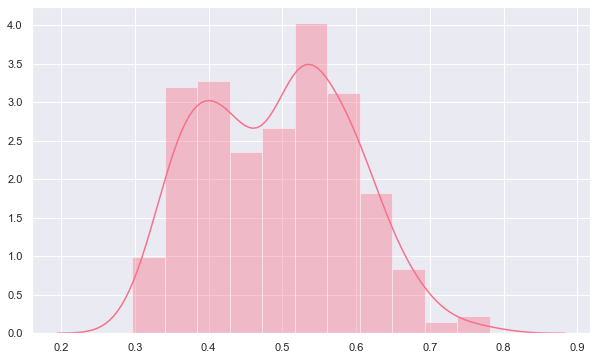

In [18]:
sns.set(palette=sns.color_palette("husl", 2), rc={"figure.figsize": (10,6)})

sns.distplot(estBestLr.predict_proba(xt.values)[:,1])

## Sample Submission Construction

Remember: You need to submit a zip file containing
- main.py
- agent.py
- example_model.pt (or the name of your model file)

### Example agent.py

In [19]:
import numpy as np
from enum import IntEnum

class Action(IntEnum):
    BUY = 0
    SELL = 1
    HOLD = 2
    
class Evaluation:
    def __init__(self, test_data, starting_cash, agent):
        self.cash = starting_cash
        self.n_shares = 0
        self.test_data = test_data
        self.except_msg = ""

        self.agent = agent

        self.n_buys = 0
        self.n_sells = 0
        self.n_holds = -1 # Always start out with a hold (so need to cancel the default +1). 
        self.account_values = []

        self.evaluate()

    def evaluate(self):
        a = Action.HOLD
        frac = 0        
        for timestep, row in self.test_data.iterrows():            
            # Catch illegal frac value
            if frac > 1:
                raise ValueError(f"You set frac to a value greater than 1 on timestep {timestep} of the test dataset")
            
            if a == Action.BUY:
                self.n_shares += frac*self.cash / row.open_today
                self.cash -= frac * self.cash
                self.n_buys += 1
            elif a == Action.SELL:
                self.cash += frac * self.n_shares * row.open_today
                self.n_shares -= frac * self.n_shares
                self.n_sells += 1
            elif a == Action.HOLD:
                self.n_holds += 1
            else:
                raise ValueError(f"Somehow you returned an illegal action (or not an action at all) on timestep {timestep} of the test dataset. Please fix and try again")

            self.account_values.append(self.total(timestep))

            a, frac = self.agent.step(row.values)

    def total(self, timestep=-1):
        return self.cash + self.n_shares * self.test_data.iloc[timestep].close_prev 

## Observations

* `frac` in buy means fraction of cash you want to use to buy shares.
  * If you have zero cash, then you're getting frac*0 / row.open shares
* `frac` in sell means fraction of shares you want to sell

So really, the crux is if I'm above the threshold, I should hold. If I'm beneath it, I should sell. There's no concept of shorting.

### Example main.py

I call this an "example", but literally this is what your main.py file should contain. (You might need to slightly change if if you mess with your agent's constructor or step function interface)

## Sample Submission Construction

Remember: You need to submit a zip file containing
- main.py
- agent.py
- example_model.pt (or the name of your model file)

## Evaluate your model

In [20]:
class AgentLWC:
    def __init__(self, adjZ):
        """
        Write your custom initialization sequence here.
        This can include loading models from file.
        """
        self.seed  = 42
        self.model = estBestLr
        self.adjZ  = adjZ

    def step(self, row):
        """
        Make a decision to be executed @ the open of the next timestep. 

        row is a numpy array with the same format as the training data

        Return a tuple (Action, fraction). Fraction means different 
        things for different actions...
        
        Action.BUY:  represents fraction of cash to spend on purchase 
        Action.SELL: represents fraction of owned shares to sell 
        Action.HOLD: value ignored.

        See the code below on how to return
        """

        datum = row.reshape([1,-1])
        z     = self.model.predict_proba(datum)[0,1] * 1.0
        zstar = np.abs(np.round(gamma(6)*z/5/gamma(5) - (5/(gamma(6)/gamma(5)) - np.log(np.exp(z))), 4))  * self.adjZ
        zstar = min(max(zstar, 0), 1)
        
        # The plan was to never have to use constants...
        # Yeah, we're assuming consistency in buy=0, sell=1, and hold=2
        if z > 0.5:
            return (Action.BUY, zstar)
        elif z <= 0.5:
            return (Action.SELL, zstar)

        return (Action.HOLD, 0)
    

In [21]:
with open("./submission006-lwac-lr_txf-24h/lwc.mdl", "rb") as f:
    testMdl = pickle.load(f)

datum = xt.iloc[0,:].values.reshape([1, -1])
testMdl.predict_proba(datum)

array([[0.63530766, 0.36469234]])

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75, 4.  , 4.25, 4.5 , 4.75])

adjZ: 1.0000
---------------Evaluation Stats---------------
total:    2954.3942917229833
cash:     2898.923255941827
n_shares: 24808.155537189843
n_buys:   152
n_sells:  145
n_holds:  0
adjZ: 1.2500
---------------Evaluation Stats---------------
total:    3348.4610874261025
cash:     3310.127912190564
n_shares: 17143.638298541264
n_buys:   152
n_sells:  145
n_holds:  0
adjZ: 1.5000
---------------Evaluation Stats---------------
total:    3700.967610215398
cash:     3675.692556806455
n_shares: 11303.69114890134
n_buys:   152
n_sells:  145
n_holds:  0
adjZ: 1.7500
---------------Evaluation Stats---------------
total:    4008.689668283429
cash:     3994.0507145677284
n_shares: 6546.938155501187
n_buys:   152
n_sells:  145
n_holds:  0
adjZ: 2.0000
---------------Evaluation Stats---------------
total:    4269.6582084082365
cash:     4262.833762783445
n_shares: 3052.077649727626
n_buys:   152
n_sells:  145
n_holds:  0
adjZ: 2.2500
---------------Evaluation Stats---------------
total:    4484

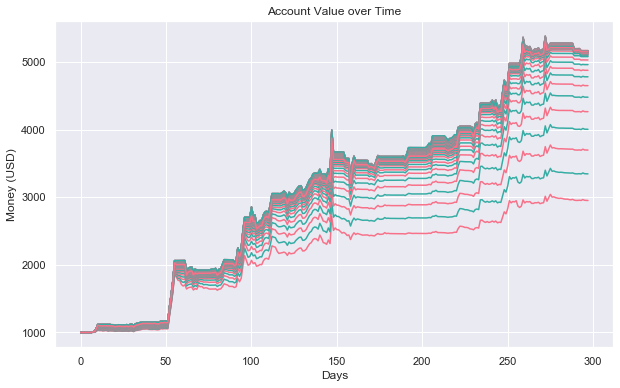

In [25]:
for adjZ in np.arange(1, 11, 0.25).tolist() + [5.0]:
    print("adjZ: %.4f" % adjZ)
    np.random.seed(42)
    agent = AgentLWC(adjZ)

    # test data, starting cash, your agent
    e = Evaluation(xt.reset_index(drop=True), 1000, agent)

    print("---------------Evaluation Stats---------------")
    print(f"total:    {e.total()}")
    print(f"cash:     {e.cash}")
    print(f"n_shares: {e.n_shares}")
    print(f"n_buys:   {e.n_buys}")
    print(f"n_sells:  {e.n_sells}")
    print(f"n_holds:  {e.n_holds}")

    plt.plot(e.account_values)
    plt.title("Account Value over Time")
    plt.xlabel("Days")
    plt.ylabel("Money (USD)")